<a href="https://colab.research.google.com/github/xanasa14/TensorFlowOptimizers/blob/master/Optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install tensorflow_hub
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

In [0]:
pd.set_option("display.precision", 8)


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
data_root='/content/drive/My Drive/shoe_images'
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

/content/drive/My Drive/shoe_images
Found 149 images belonging to 5 classes.
Found 601 images belonging to 5 classes.


In [11]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)
['Nike_Air_Max_Plus' 'Nike_Court_Royale' 'Nike_Downshifter'
 'Nike_Md_Runner' 'Nike_Nightgazer']


In [13]:
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adadelta(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_7 (Dense)              multiple                  6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit_generator(
train_generator,
epochs=10,
verbose=1,

steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

Epoch 1/10
 1/19 [>.............................] - ETA: 7:58 - loss: 1.9559 - acc: 0.2812

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/19 [==============================] - 516s 27s/step - loss: 1.9208 - acc: 0.2416 - val_loss: 1.6186 - val_acc: 0.2617
Epoch 2/10
19/19 [==============================] - 38s 2s/step - loss: 1.9818 - acc: 0.2057 - val_loss: 1.5943 - val_acc: 0.2617
Epoch 3/10
19/19 [==============================] - 38s 2s/step - loss: 1.9665 - acc: 0.1769 - val_loss: 1.5978 - val_acc: 0.2617
Epoch 4/10
19/19 [==============================] - 38s 2s/step - loss: 1.9870 - acc: 0.2050 - val_loss: 1.5998 - val_acc: 0.2752
Epoch 5/10
19/19 [==============================] - 38s 2s/step - loss: 1.9490 - acc: 0.1948 - val_loss: 1.5883 - val_acc: 0.2685
Epoch 6/10
19/19 [==============================] - 38s 2s/step - loss: 1.9468 - acc: 0.2129 - val_loss: 1.5874 - val_acc: 0.2685
Epoch 7/10
19/19 [==============================] - 38s 2s/step - loss: 1.9038 - acc: 0.1972 - val_loss: 1.5871 - val_acc: 0.2685
Epoch 8/10
19/19 [==============================] - 38s 2s/step - loss: 1.8836 - acc: 0.2299 - val_

In [15]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)
tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

Validation batch shape: (32, 224, 224, 3)
Prediction results for the first elements


,Nike_Air_Max_Plus,Nike_Court_Royale,Nike_Downshifter,Nike_Md_Runner,Nike_Nightgazer
0,0.35727656,0.07498475,0.12231014,0.27665898,0.16876960
1,0.41673335,0.21532567,0.10616053,0.14291567,0.11886486
2,0.26231566,0.17252894,0.15131392,0.23385723,0.17998424
3,0.22485389,0.14269076,0.17857508,0.22980340,0.22407687
4,0.46596673,0.16803005,0.10808954,0.16477083,0.09314284


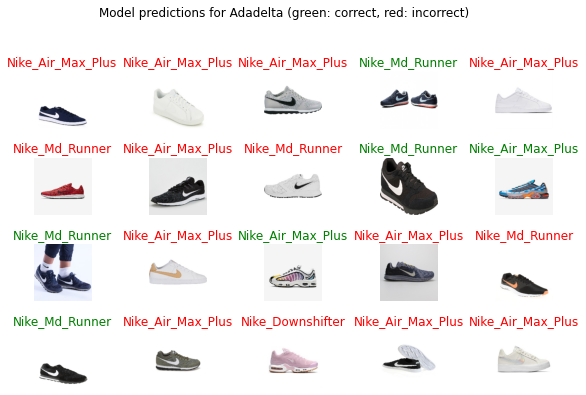

In [18]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions for Adadelta (green: correct, red: incorrect)")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
dense_10 (Dense)             multiple                  6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/19 [==============================] - 44s 2s/step - loss: 1.7684 - acc: 0.2338 - val_loss: 1.4232 - val_acc: 0.3758
Epoch 2/10
19/19 [==============================] - 37s 2s/step - loss: 1.5233 - acc: 0.3613 - val_loss: 1.2809 - val_acc: 0.4564
Epoch 3/10
19/19 [==============================] - 37s 2s/step - loss: 1.4104 - acc: 0.3740 - val_loss: 1.1992 - val_acc: 0.4966
Epoch 4/10
19/19 [==============================] - 37s 2s/step - loss: 1.3560 - acc: 0.3548 - val_loss: 1.1144 - val_acc: 0.5772
Epoch 5/10
19/19 [==============================] - 38s 2s/step - loss: 1.2796 - acc: 0.4463 - val_loss: 1.0619 - val_acc: 0.5772
Epoch 6/10
19/19 [==============================] - 37s 2s/step - loss: 1.2138 - acc: 0.4757 - val_loss: 1.0349 - val_acc: 0.6107
Epoch 7/10
19/19 [==============================] - 37s 2s/step - loss: 1.1515 - acc: 0.5057 - val_loss: 0.9915 - val_acc: 0.6309
Epoch 8/10
19/19 [==============================] - 37s 2s/step - loss: 1.1600 - acc: 0.5263 - val_lo

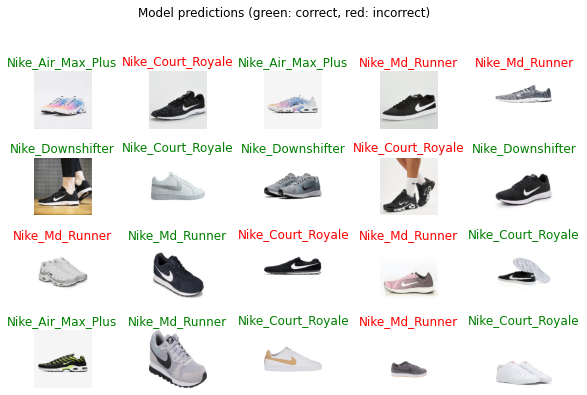

In [21]:
model2 = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model2.build([None, 224, 224, 3])
model2.summary()
model2.compile(
optimizer=tf.keras.optimizers.Adagrad(),
loss='categorical_crossentropy',
metrics=['acc'])
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model2.fit_generator(
train_generator,
epochs=10,
verbose=1,

steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history


val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)
tf_model_predictions = model2.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions Adagrad (green: correct, red: incorrect)")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
dense_12 (Dense)             multiple                  6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/19 [==============================] - 45s 2s/step - loss: 1.4686 - acc: 0.2930 - val_loss: 1.0583 - val_acc: 0.6040
Epoch 2/10
19/19 [==============================] - 37s 2s/step - loss: 0.9370 - acc: 0.5774 - val_loss: 0.7830 - val_acc: 0.7383
Epoch 3/10
19/19 [==============================] - 38s 2s/step - loss: 0.7580 - acc: 0.6913 - val_loss: 0.6438 - val_acc: 0.8322
Epoch 4/10
19/19 [==============================] - 37s 2s/step - loss: 0.5921 - acc: 0.7668 - val_loss: 0.5548 - val_acc: 0.8591
Epoch 5/10
19/19 [==============================] - 37s 2s/step - loss: 0.5119 - acc: 0.8289 - val_loss: 0.5156 - val_acc: 0.8658
Epoch 6/10
19/19 [==============================] - 37s 2s/step - loss: 0.4759 - acc: 0.8088 - val_loss: 0.4640 - val_acc: 0.8926
Epoch 7/10
19/19 [==============================] - 37s 2s/step - loss: 0.4654 - acc: 0.8388 - val_loss: 0.4378 - val_acc: 0.9060
Epoch 8/10
19/19 [==============================] - 37s 2s/step - loss: 0.4080 - acc: 0.8379 - val_lo

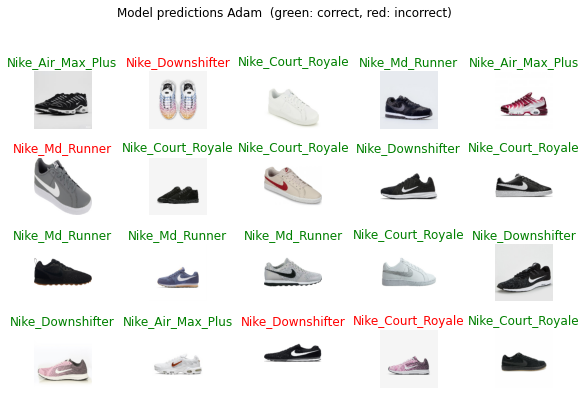

In [23]:
model3 = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model3.build([None, 224, 224, 3])
model3.summary()
model3.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model3.fit_generator(
train_generator,
epochs=10,
verbose=1,

steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history


val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)
tf_model_predictions = model3.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions Adam  (green: correct, red: incorrect)")

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_8 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_8 (Dropout)          multiple                  0         
_________________________________________________________________
dense_14 (Dense)             multiple                  6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/19 [==============================] - 47s 2s/step - loss: 1.6678 - acc: 0.2447 - val_loss: 1.2237 - val_acc: 0.4161
Epoch 2/10
19/19 [==============================] - 37s 2s/step - loss: 1.2574 - acc: 0.4351 - val_loss: 1.0114 - val_acc: 0.6174
Epoch 3/10
19/19 [==============================] - 37s 2s/step - loss: 1.0842 - acc: 0.5004 - val_loss: 0.8888 - val_acc: 0.6980
Epoch 4/10
19/19 [==============================] - 37s 2s/step - loss: 0.9597 - acc: 0.5970 - val_loss: 0.8054 - val_acc: 0.7383
Epoch 5/10
19/19 [==============================] - 37s 2s/step - loss: 0.8451 - acc: 0.6360 - val_loss: 0.7558 - val_acc: 0.7852
Epoch 6/10
19/19 [==============================] - 37s 2s/step - loss: 0.8184 - acc: 0.6555 - val_loss: 0.6932 - val_acc: 0.8188
Epoch 7/10
19/19 [==============================] - 38s 2s/step - loss: 0.7329 - acc: 0.7102 - val_loss: 0.6493 - val_acc: 0.8389
Epoch 8/10
19/19 [==============================] - 37s 2s/step - loss: 0.7027 - acc: 0.7401 - val_lo

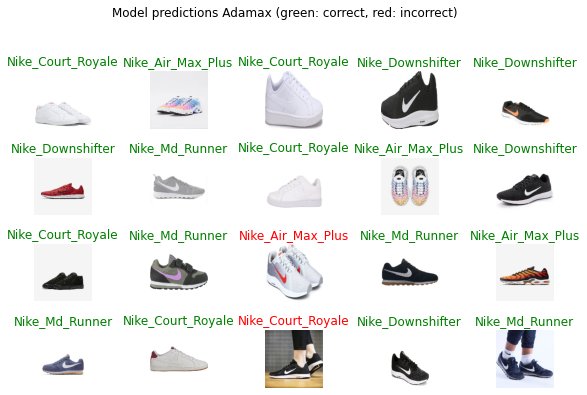

In [25]:
model4 = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model4.build([None, 224, 224, 3])
model4.summary()
model4.compile(
optimizer=tf.keras.optimizers.Adamax(),
loss='categorical_crossentropy',
metrics=['acc'])
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model4.fit_generator(
train_generator,
epochs=10,
verbose=1,

steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history


val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)
tf_model_predictions = model4.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions Adamax (green: correct, red: incorrect)")

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_14 (KerasLayer)  multiple                  2257984   
_________________________________________________________________
dropout_14 (Dropout)         multiple                  0         
_________________________________________________________________
dense_20 (Dense)             multiple                  6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/19 [==============================] - 50s 3s/step - loss: 1.3265 - acc: 0.3937 - val_loss: 0.9065 - val_acc: 0.6577
Epoch 2/10
19/19 [==============================] - 38s 2s/step - loss: 0.8975 - acc: 0.6084 - val_loss: 0.6814 - val_acc: 0.7450
Epoch 3/10
19/19 [==============================] - 37s 2s/step - loss: 0.7396 - acc: 0.7134 - val_loss: 0.6218 - val_acc: 0.7450
Epoch 4/10
19/19 [==============================] - 38s 2s/step - loss: 0.6227 - acc: 0.7334 - val_loss: 0.5223 - val_acc: 0.8456
Epoch 5/10
19/19 [==============================] - 38s 2s/step - loss: 0.5689 - acc: 0.7606 - val_loss: 0.4425 - val_acc: 0.8859
Epoch 6/10
19/19 [==============================] - 37s 2s/step - loss: 0.4576 - acc: 0.8488 - val_loss: 0.4066 - val_acc: 0.8993
Epoch 7/10
19/19 [==============================] - 37s 2s/step - loss: 0.4080 - acc: 0.8755 - val_loss: 0.4143 - val_acc: 0.8926
Epoch 8/10
19/19 [==============================] - 37s 2s/step - loss: 0.3855 - acc: 0.8479 - val_lo

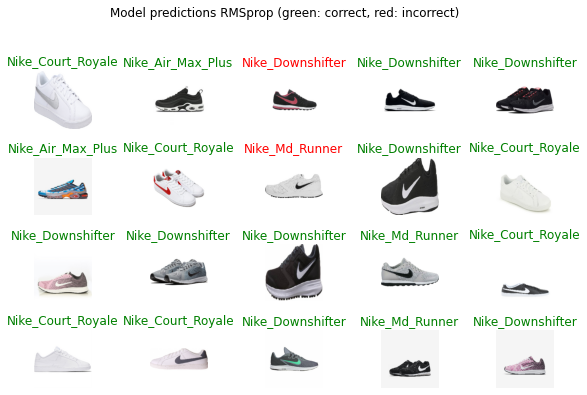

In [31]:
model5 = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model5.build([None, 224, 224, 3])
model5.summary()
model5.compile(
optimizer=tf.keras.optimizers.RMSprop(),
loss='categorical_crossentropy',
metrics=['acc'])
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model5.fit_generator(
train_generator,
epochs=10,
verbose=1,

steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history


val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)
tf_model_predictions = model5.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions RMSprop (green: correct, red: incorrect)")

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_17 (KerasLayer)  multiple                  2257984   
_________________________________________________________________
dropout_17 (Dropout)         multiple                  0         
_________________________________________________________________
dense_23 (Dense)             multiple                  6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/19 [==============================] - 53s 3s/step - loss: 1.6124 - acc: 0.2554 - val_loss: 1.0465 - val_acc: 0.5638
Epoch 2/10
19/19 [==============================] - 37s 2s/step - loss: 1.0901 - acc: 0.4925 - val_loss: 0.8428 - val_acc: 0.7047
Epoch 3/10
19/19 [==============================] - 38s 2s/step - loss: 0.9040 - acc: 0.6326 - val_loss: 0.6936 - val_acc: 0.7651
Epoch 4/10
19/19 [==============================] - 37s 2s/step - loss: 0.7163 - acc: 0.7446 - val_loss: 0.6314 - val_acc: 0.8322
Epoch 5/10
19/19 [==============================] - 38s 2s/step - loss: 0.6874 - acc: 0.7825 - val_loss: 0.5594 - val_acc: 0.8255
Epoch 6/10
19/19 [==============================] - 38s 2s/step - loss: 0.5955 - acc: 0.7953 - val_loss: 0.5152 - val_acc: 0.8456
Epoch 7/10
19/19 [==============================] - 38s 2s/step - loss: 0.5675 - acc: 0.8083 - val_loss: 0.4899 - val_acc: 0.8792
Epoch 8/10
19/19 [==============================] - 38s 2s/step - loss: 0.5104 - acc: 0.8585 - val_lo

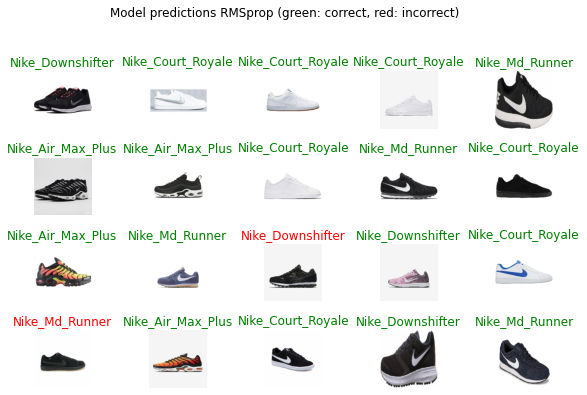

In [34]:
model6 = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model6.build([None, 224, 224, 3])
model6.summary()
model6.compile(
optimizer=tf.keras.optimizers.SGD(),
loss='categorical_crossentropy',
metrics=['acc'])
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model6.fit_generator(
train_generator,
epochs=10,
verbose=1,

steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history


val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)
tf_model_predictions = model6.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions RMSprop (green: correct, red: incorrect)")